### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric Temporal

In [3]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torch_geometric
!pip install torch-scatter

2.1.0+cu118
11.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3544165 sha256=baaae6df32c75efa9dc5376727ccc783abbd964a6d117cf9ff9daeaa6f88588e
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter


In [2]:
import os
import torch
import numpy as np

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [3]:
import json
from itertools import repeat
from torch_geometric.data import InMemoryDataset, Data
from tqdm.notebook import tqdm
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, remove_self_loops

MAX_VALID_DISTANCE = 0.3  # Adjust this value based on domain knowledge

def calculate_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

@staticmethod
def calculate_angle(p1, p2, p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Clamp the cosine_angle between -1 and 1 to avoid invalid values
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

class ASLInMemoryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(ASLInMemoryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.splitext(filename)[0] for filename in os.listdir(self.raw_dir)]

    @property
    def processed_file_names(self):
        return ['processed_data.pt']

    def download(self):
        # We're using local files, so no need to implement download logic
        pass

    def process(self):
        data_list = []

        loader = ASLDatasetLoader(self.raw_dir)
        self._sign_to_label = loader.sign_to_label
        dataset = loader.get_dataset()

        # If you want to add a progress bar, use tqdm here
        # dataset = tqdm(dataset, desc="Processing dataset", leave=False)

        data_list.extend(dataset)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return len(self._data.y)

    def get(self, idx):
        data = Data()
        for key in self._data.keys():
            item, slices = self._data[key], self.slices[key]
            s = list(repeat(slice(None), item.dim()))
            s[self._data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        return data

    def sign_to_label(self):
        return self._sign_to_label

class ASLDatasetLoader:
    RELEVANT_LANDMARKS = {
        *['pose-' + str(i) for i in [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]],
        *['face-' + str(i) for i in [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 61, 62, 63, 64, 66, 291, 292, 293, 294, 295, 296]],
        *['right_hand-' + str(i) for i in range(21)],  # Keeping all right hand landmarks
        *['left_hand-' + str(i) for i in range(21)],   # Keeping all left hand landmarks
    }

    # Right hand connections
    RIGHT_HAND_CONNECTIONS = [
        *[(f'right_hand-{i}', f'right_hand-{i + 1}') for i in range(4)],  # Thumb
        *[(f'right_hand-{i}', f'right_hand-{i + 1}') for i in range(5, 8)],  # Index finger
        *[(f'right_hand-{i}', f'right_hand-{i + 1}') for i in range(9, 12)],  # Middle finger
        *[(f'right_hand-{i}', f'right_hand-{i + 1}') for i in range(13, 16)],  # Ring finger
        *[(f'right_hand-{i}', f'right_hand-{i + 1}') for i in range(17, 20)],  # Pinky
        (f'right_hand-0', f'right_hand-5'), (f'right_hand-5', f'right_hand-9'),
        (f'right_hand-9', f'right_hand-13'), (f'right_hand-13', f'right_hand-17')
    ]

    # Left hand connections
    LEFT_HAND_CONNECTIONS = [
        *[(f'left_hand-{i}', f'left_hand-{i + 1}') for i in range(4)],  # Thumb
        *[(f'left_hand-{i}', f'left_hand-{i + 1}') for i in range(5, 8)],  # Index finger
        *[(f'left_hand-{i}', f'left_hand-{i + 1}') for i in range(9, 12)],  # Middle finger
        *[(f'left_hand-{i}', f'left_hand-{i + 1}') for i in range(13, 16)],  # Ring finger
        *[(f'left_hand-{i}', f'left_hand-{i + 1}') for i in range(17, 20)],  # Pinky
        (f'left_hand-0', f'left_hand-5'), (f'left_hand-5', f'left_hand-9'),
        (f'left_hand-9', f'left_hand-13'), (f'left_hand-13', f'left_hand-17')
    ]

    # Pose connections
    POSE_CONNECTIONS = [
        ('pose-0', 'pose-1'), ('pose-1', 'pose-2'), ('pose-2', 'pose-3'), ('pose-0', 'pose-4'),
        ('pose-4', 'pose-5'), ('pose-5', 'pose-6'), ('pose-0', 'pose-9'), ('pose-9', 'pose-10'),
        ('pose-10', 'pose-11'), ('pose-11', 'pose-12'), ('pose-12', 'pose-24'), ('pose-24', 'pose-26'),
        ('pose-26', 'pose-28'), ('pose-0', 'pose-13'), ('pose-13', 'pose-14'), ('pose-14', 'pose-15'),
        ('pose-15', 'pose-16'), ('pose-16', 'pose-22'), ('pose-22', 'pose-24'), ('pose-24', 'pose-26'),
        ('pose-26', 'pose-28'), ('pose-11', 'pose-23'), ('pose-23', 'pose-25'), ('pose-25', 'pose-27'),
        ('pose-15', 'pose-19'), ('pose-19', 'pose-21'), ('pose-21', 'pose-23'), ('pose-23', 'pose-25'),
        ('pose-25', 'pose-27')
    ]

    # Face connections (selected key points for simplicity)
    FACE_CONNECTIONS = [
        ('face-33', 'face-133'), ('face-133', 'face-246'), ('face-246', 'face-161'), ('face-161', 'face-160'),
        ('face-160', 'face-159'), ('face-159', 'face-158'), ('face-158', 'face-157'), ('face-157', 'face-173'),
        ('face-173', 'face-133'), ('face-33', 'face-7'), ('face-7', 'face-163'), ('face-163', 'face-144'),
        ('face-144', 'face-145'), ('face-145', 'face-153'), ('face-153', 'face-154'), ('face-154', 'face-155'),
        # ... (add other face connections as needed)
    ]

    # Inter-connections between Pose, Face, and Hands
    INTER_CONNECTIONS = [
        ('pose-7', 'right_hand-0'), ('pose-8', 'left_hand-0'),  # Connecting hands to the arms
        ('pose-1', 'face-133')  # Connecting shoulders to the face (you can adjust this based on your needs)
    ]

    HAND_CONNECTIONS = RIGHT_HAND_CONNECTIONS + LEFT_HAND_CONNECTIONS
    ALL_CONNECTIONS = HAND_CONNECTIONS + POSE_CONNECTIONS + FACE_CONNECTIONS + INTER_CONNECTIONS


    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.sign_to_label = self._create_sign_to_label_map()

    @staticmethod
    def calculate_distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    @staticmethod
    def calculate_angle(p1, p2, p3):
        a = np.array(p1)
        b = np.array(p2)
        c = np.array(p3)
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        return np.degrees(angle)

    def normalize_landmarks(self, landmarks):
        reference = landmarks[16]  # 17th landmark
        normalized_landmarks = [(x - reference[0], y - reference[1]) for x, y in landmarks]
        return normalized_landmarks

    def _create_sign_to_label_map(self):
        signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]
        return {sign: i for i, sign in enumerate(signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    @staticmethod
    def interpolate_landmark(landmark1, landmark2, alpha):
        """
        Linearly interpolate between two landmarks.

        Parameters:
        - landmark1: The first landmark
        - landmark2: The second landmark
        - alpha: The interpolation factor. 0.0 returns landmark1, 1.0 returns landmark2.

        Returns:
        - Interpolated landmark
        """
        return landmark1 * (1 - alpha) + landmark2 * alpha

    def _create_graph_from_frame(self, sign_name, frame_data, previous_frame_data=None):
        landmarks = np.array(frame_data["landmarks"])
        landmark_types = frame_data["landmark_types"]

        # Normalize the landmarks using the 17th landmark as the reference
        landmarks = self.normalize_landmarks(landmarks)

        # Check directly after extracting landmarks
        if np.isnan(landmarks).any() or np.isinf(landmarks).any():
            print("NaN or Inf found in landmarks!")

        # Filter out irrelevant landmarks
        relevant_landmarks = [(i, lt) for i, lt in enumerate(landmark_types) if lt in self.RELEVANT_LANDMARKS]
        relevant_indices = [i for i, _ in relevant_landmarks]
        relevant_landmark_types = [lt for _, lt in relevant_landmarks]

        # Update landmarks to consider only relevant landmarks
        landmarks = np.array([landmarks[i] for i in relevant_indices])

        # Node features: x, y coordinates
        x = torch.tensor(landmarks, dtype=torch.float)

        # Spatial edges and their features
        spatial_edges = []
        spatial_edge_distances = []
        spatial_edge_angles = []

        # Add spatial edges based on physical connectivity
        for (start, end) in self.ALL_CONNECTIONS:
            if start in relevant_landmark_types and end in relevant_landmark_types:
                start_idx = relevant_landmark_types.index(start)
                end_idx = relevant_landmark_types.index(end)
                distance = self.calculate_distance(landmarks[start_idx], landmarks[end_idx])
                if distance < MAX_VALID_DISTANCE:
                    spatial_edges.append([start_idx, end_idx])
                    spatial_edge_distances.append(distance)
                    if end_idx < len(landmarks) - 1:
                        spatial_edge_angles.append(self.calculate_angle(landmarks[start_idx], landmarks[end_idx], landmarks[end_idx + 1]))
                    else:
                        spatial_edge_angles.append(0.0)

        # Temporal edges and their features
        temporal_edges = []
        temporal_edge_deltas = []
        if previous_frame_data:
            prev_landmarks = np.array(previous_frame_data["landmarks"])
            prev_landmark_types = previous_frame_data["landmark_types"]

            # Filter out irrelevant landmarks from previous frame
            relevant_prev_landmarks = [(i, lt) for i, lt in enumerate(prev_landmark_types) if lt in self.RELEVANT_LANDMARKS]
            relevant_prev_indices = [i for i, _ in relevant_prev_landmarks]
            relevant_prev_landmark_types = [lt for _, lt in relevant_prev_landmarks]

            # Update prev_landmarks to consider only relevant landmarks
            prev_landmarks = prev_landmarks[relevant_prev_indices]

            for i, (lt1, lt2) in enumerate(zip(relevant_landmark_types, relevant_prev_landmark_types)):
                if lt1 == lt2:
                    interpolated_landmark = self.interpolate_landmark(prev_landmarks[i], landmarks[i], 0.5)
                    temporal_edges.append([i, i])
                    temporal_edge_deltas.append(self.calculate_distance(interpolated_landmark, landmarks[i]))

        # Ensure each edge has 3 features: distance, angle, and delta
        num_spatial_edges = len(spatial_edges)
        num_temporal_edges = len(temporal_edges)
        edge_attr = torch.zeros(num_spatial_edges + num_temporal_edges, 3, dtype=torch.float)

        if spatial_edges:
            edge_attr[:num_spatial_edges, 0] = torch.tensor(spatial_edge_distances)
            edge_attr[:num_spatial_edges, 1] = torch.tensor(spatial_edge_angles)

        if temporal_edges:
            edge_attr[-num_temporal_edges:, 2] = torch.tensor(temporal_edge_deltas)

        edge_index = torch.tensor(spatial_edges + temporal_edges, dtype=torch.long).t().contiguous()
        y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    def get_dataset(self):
        dataset = []

        for filename in os.listdir(self.directory_path):
            sign_name = os.path.splitext(filename)[0]
            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)

            for example in sign_data["examples"]:

                concatenated_data = Data(
                    x=torch.tensor([], dtype=torch.float),
                    edge_index=torch.tensor([], dtype=torch.long).t().contiguous(),
                    edge_attr=torch.tensor([], dtype=torch.float).view(0, 3),  # Adjusted size here
                    y=torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)
                )

                prev_frame_data = None
                for frame_data in example["frames"]:
                    graph_data = self._create_graph_from_frame(sign_name, frame_data, prev_frame_data)

                    # print("concatenated_data.edge_attr.shape:", concatenated_data.edge_attr.shape)
                    # print("graph_data.edge_attr.shape:", graph_data.edge_attr.shape)

                    # Calculate the offset for edge indices
                    offset = concatenated_data.x.size(0)  # This is the number of nodes already in concatenated_data

                    # Update the edge indices of graph_data with the offset
                    graph_data.edge_index += offset  # <-- This is the critical change

                    concatenated_data.x = torch.cat([concatenated_data.x, graph_data.x], dim=0)
                    concatenated_data.edge_index = torch.cat([concatenated_data.edge_index, graph_data.edge_index], dim=1)
                    concatenated_data.edge_attr = torch.cat([concatenated_data.edge_attr, graph_data.edge_attr], dim=0)

                    prev_frame_data = frame_data

                # Ensure each node has a self-loop
                concatenated_data.edge_index, _ = add_self_loops(concatenated_data.edge_index, num_nodes=concatenated_data.x.size(0))
                dataset.append(concatenated_data)

        return dataset


    def number_of_classes(self):
        return len(self.sign_to_label)

### `ASLGraphClassifier` Class

The `ASLGraphClassifier`, features deeper GCN layers and additional channels to capture intricate data patterns potentially. It takes a PyG `Data` object as input, and its forward pass emits class logits.

**Methods**:

- `forward`: Details the forward pass, accepting a PyG `Data` object. Two GCN layers with subsequent batch normalization and dropout layers process the input. Post global max-pooling, two linear layers coupled with dropout ensure final classification, leading to log-softmax outputs.

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool, global_mean_pool

class ASLGraphClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(ASLGraphClassifier, self).__init__()

        W = 512  # Base width for the model

        # 1st GCN layer
        self.conv1 = GCNConv(num_features, W)
        self.bn1 = torch.nn.BatchNorm1d(W, momentum=0.1)

        # 2nd GCN layer
        self.conv2 = GCNConv(W, 2*W)
        self.bn2 = torch.nn.BatchNorm1d(2*W, momentum=0.1)

        # For the residual connection
        self.residual_transform1 = torch.nn.Linear(W, 2*W)

        # GAT layer
        self.gat = GATConv(2*W, 2*W, heads=4, concat=True)
        self.bn3 = torch.nn.BatchNorm1d(2*W*4, momentum=0.1)

        # For the residual connection after GAT
        self.residual_transform2 = torch.nn.Linear(2*W, 2*W*4)

        self.lin1 = torch.nn.Linear(2*W*4*2, 2*W)  # *2 for max and mean pooling
        self.lin2 = torch.nn.Linear(2*W, num_classes)

        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st GCN layer
        x1 = F.relu(self.conv1(x, edge_index))
        x1 = self.bn1(x1)
        x1 = self.dropout(x1)

        # 2nd GCN layer with residual connection
        x2 = F.relu(self.conv2(x1, edge_index))
        x2 = self.bn2(x2 + self.residual_transform1(x1))
        x2 = self.dropout(x2)

        # GAT layer with residual connection
        x3 = F.relu(self.gat(x2, edge_index))
        x3 = self.bn3(x3 + self.residual_transform2(x2))
        x3 = self.dropout(x3)

        # Combining max and mean pooling
        x_max = global_max_pool(x3, batch)
        x_mean = global_mean_pool(x3, batch)
        x = torch.cat([x_max, x_mean], dim=1)

        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)

        return F.log_softmax(x, dim=1)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
from torch.cuda.amp import GradScaler, autocast

EPOCHS = 100
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 7
GRADIENT_ACCUM_STEPS = 4  # For gradient accumulation
WORKERS = 2

def stratified_data_split(data_list, test_size=0.2):
    labels = [data.y.item() for data in data_list]
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)
    return train_data, test_data

def validate(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    accuracy = (all_preds == all_labels).float().mean().item()

    metrics = {
        'accuracy': accuracy,
        'precision': precision_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'recall': recall_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1),
        'f1': f1_score(all_labels.numpy(), all_preds.numpy(), average='macro', zero_division=1)
    }
    return metrics

def train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the use_amp variable
    use_amp = torch.cuda.is_available()

    num_features = train_data[0].num_node_features
    num_classes = len(set([data.y.item() for data in train_data]))
    model = ASLGraphClassifier(num_features=num_features, num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=2, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()

    # Only instantiate the GradScaler if CUDA is available
    if use_amp:
        scaler = GradScaler()
    else:
        scaler = None  # or you could use a dummy scaler that doesn't do anything


    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
    train_loader = tqdm(train_loader, desc="Data Loading...", leave=False)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        optimizer.zero_grad()

        for idx, data in enumerate(train_loader):
            # print(f"Batch {idx+1}")
            # print(data.edge_index)
            # print("---------")
            data = data.to(device)

            # Conditional autocast based on use_amp
            if use_amp:
                with autocast():
                    out = model(data)
                    loss = criterion(out, data.y)
            else:
                out = model(data)
                loss = criterion(out, data.y)

            # Conditional scaler step based on use_amp
            if use_amp:
                scaler.scale(loss / GRADIENT_ACCUM_STEPS).backward()

                if (idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                loss.backward()

                if (idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(data.y.cpu())
            total_loss += loss.item()

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_accuracy = (all_preds == all_labels).float().mean().item()

        avg_loss = total_loss / len(train_data)

        val_metrics = validate(val_loader, model, device)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}")

        scheduler.step(val_metrics['accuracy'])

        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epochs_without_improvement} epochs without validation accuracy improvement.")
            break

        torch.cuda.empty_cache()

    return model, all_preds, all_labels, train_accuracy

In [6]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/ASL4/"

# Create an instance of the ASLInMemoryDataset
dataset = ASLInMemoryDataset(root=directory_path)

In [7]:
# Split the dataset into training and validation subsets
train_data, val_data = stratified_data_split(dataset)

In [8]:
# Train the model using the datasets
model, all_preds, all_labels, accuracy = train(train_data, val_data, epochs=EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Data Loading...:   0%|          | 0/229 [00:00<?, ?it/s]

OutOfMemoryError: ignored

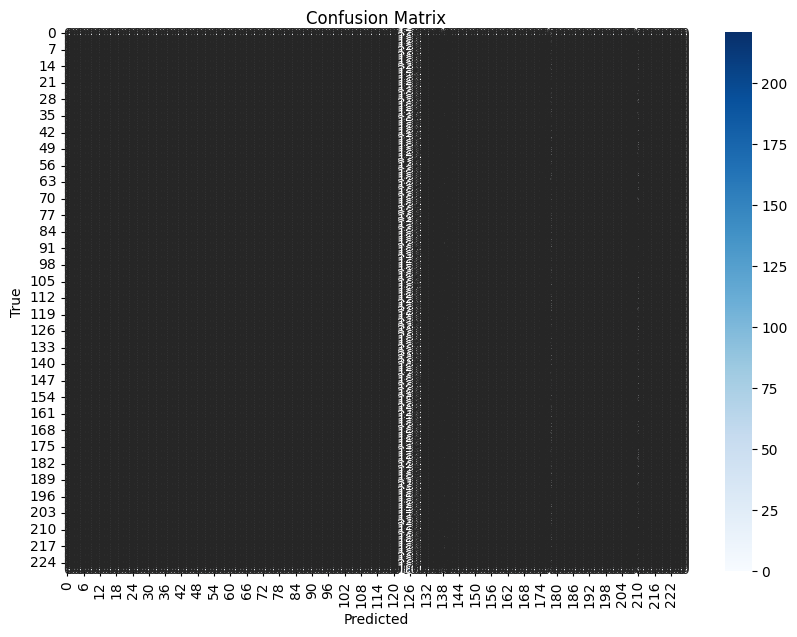

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted(dataset.sign_to_label.items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [ ]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [ ]:
print_top_misclassified_classes(y_true, y_pred, dataset.sign_to_label, N=10, zero_division=1)